# News Article Summarization and Keyword Extraction via NLP

In this demo, we will create an NLP pipeline that will summarize and extract keywords from a news article URL. We will be using state-of-the-art transformer models such as BERT to perform these NLP tasks.

Additionally, we will be using MLRun's real-time inference graphs to create the pipeline. This allows for easy containerization and deployment of our pipeline on top of a production-ready Kubernetes cluster.

The full pipeline will do the following:
1. Retrieve news article text and metadata from URL using newspaper3k
2. Summarize article text via Huggingface pipeline using DistilBart model
3. Extract article keywords via KeyBERT using BERT-embeddings and cosine similarity
4. Remove the original article text from the response (optional)
5. Persist record in KV table

### Install Local Dependencies

In [1]:
!pip install transformers==4.11.3 newspaper3k==0.2.8 keybert==0.5.0

     |████████████████████████████████| 2.9 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 211 kB 99.2 MB/s eta 0:00:01
     |████████████████████████████████| 751 kB 100.5 MB/s eta 0:00:01
     |████████████████████████████████| 101 kB 96.2 MB/s ta 0:00:01
     |████████████████████████████████| 3.3 MB 94.0 MB/s eta 0:00:01
     |████████████████████████████████| 880 kB 99.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 78.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 87.8 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 93.9 MB/s eta 0:00:01
     |████████████████████████████████| 7.4 MB 86.5 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 62.4 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 88.0 MB/s eta 0:00:01
     |████████████████████████████████| 235 kB 102.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 89.1 MB/s eta 0:00:01
     |███████████████████████████████

### Define MLRun Function
Here we define the serverless function that will containerize and deploy our application. We can add dependencies and commands to the image build, define replicas for scaling, add environment variables, and more.

In [2]:
import os
import mlrun

In [3]:
project_name = "nlp-demo"
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2022-07-27 19:01:08,070 [info] created and saved project nlp-demo


In [4]:
fn = mlrun.code_to_function(name="news-article-nlp", filename="nlp_transformations.py",
                            kind="serving", image='mlrun/ml-models')
fn.spec.min_replicas = 1
fn.spec.max_replicas = 1
fn.spec.build.commands = [
    "python -m pip install transformers==4.11.3 newspaper3k==0.2.8 keybert==0.5.0",
    "python -c 'from transformers import pipeline; pipeline(\"summarization\")'",
    "python -c 'from keybert import KeyBERT; KeyBERT()'"
]

### Define Real-Time Serving Graph
Here we will orchestrate the functions and classes we want to run in our pipeline. The source code for these functions is located in `project/nlp_transformations.py`. Notice, this is the same file we used when running `code_to_function` in the cell above.

In [5]:
container = "bigdata"
table_path = f"nlp-{os.getenv('V3IO_USERNAME')}"
key = "title"

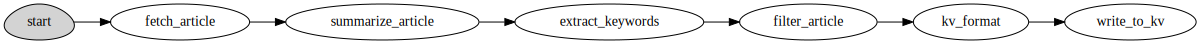

In [6]:
graph = fn.set_topology("flow", engine="async")

graph.to(name="fetch_article", handler="fetch_article")\
     .to(name="summarize_article", class_name="SummarizeArticle")\
     .to(name="extract_keywords", class_name="ExtractKeywords")\
     .to(name="filter_article", handler="filter_article")\
     .to(name="kv_format", handler="kv_format", full_event=True)\
     .to(name="write_to_kv", class_name="storey.NoSqlTarget", table=f"v3io:///{container}/{table_path}").respond()

graph.plot(rankdir='LR')

### Test the Pipeline Locally (using simulator)

In [7]:
# import the step functions for simulation
from nlp_transformations import *

# create a mock server (simulator)
server = fn.to_mock_server()

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/c10/cuda/CUDAFunctions.cpp:100.)


In [8]:
# test the pipeline
server.test("/", body={"url" : "https://www.cnn.com/2021/11/01/politics/vaccine-rules-osha/index.html"})

{'url': 'https://www.cnn.com/2021/11/01/politics/vaccine-rules-osha/index.html',
 'title': 'Emergency vaccine rule for large employers will be issued in the coming days',
 'authors': '["Kaitlan Collins", "Kate Sullivan"]',
 'publish_date': '2021-11-01 00:00:00',
 'summarized_text': ' The Federal Register will publish the Labor Departments emergency temporary standard in the coming days . The rule requires private businesses with 100 or more employees to vaccinate or test them weekly . President Joe Biden announced the rule in September . Employers must develop, implement, and enforce a mandatory COVID-19 vaccination policy .',
 'keywords': '["vaccination", "compliance", "announced", "biden", "emergency"]'}

### Containerize and Deploy Pipeline on K8s
Here we easily containerize and deploy our application to our K8s cluster with a single command.

In [9]:
fn.spec.readinessTimeoutSeconds = 60 * 20  # 20 minutes.\n",
fn.deploy()

> 2022-07-27 19:02:17,488 [info] Starting remote function deploy
2022-07-27 19:02:17  (info) Deploying function
2022-07-27 19:02:17  (info) Building
2022-07-27 19:02:17  (info) Staging files and preparing base images
2022-07-27 19:02:17  (info) Building processor image
2022-07-27 19:06:53  (info) Build complete
2022-07-27 19:07:31  (info) Function deploy complete
> 2022-07-27 19:07:32,077 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-nlp-demo-nick-news-article-nlp.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['nlp-demo-nick-news-article-nlp-nlp-demo-nick.default-tenant.app.uss-sales-350.iguazio-cd2.com/']}


'http://nlp-demo-nick-news-article-nlp-nlp-demo-nick.default-tenant.app.uss-sales-350.iguazio-cd2.com/'

### Test Pipeline with URLs From Various News Sources 
Here we can test the pipeline with various news sources. This pipeline should work with any source compatible with the `newspaper3k` Python library.

In [10]:
fn.invoke(
    path="/",
    body={"url" : "https://www.cnn.com/2021/11/01/politics/vaccine-rules-osha/index.html"}
)

> 2022-07-27 19:07:41,291 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-nick-news-article-nlp.default-tenant.svc.cluster.local:8080/'}


{'url': 'https://www.cnn.com/2021/11/01/politics/vaccine-rules-osha/index.html',
 'title': 'Emergency vaccine rule for large employers will be issued in the coming days',
 'authors': '["Kaitlan Collins", "Kate Sullivan"]',
 'publish_date': '2021-11-01 00:00:00',
 'summarized_text': ' The Federal Register will publish the Labor Departments emergency temporary standard in the coming days . The rule requires private businesses with 100 or more employees to vaccinate or test them weekly . President Joe Biden announced the rule in September . Employers must develop, implement, and enforce a mandatory COVID-19 vaccination policy .',
 'keywords': '["vaccination", "compliance", "announced", "biden", "emergency"]'}

In [11]:
fn.invoke(
    path="/",
    body={"url" : "https://www.cnn.com/travel/article/americans-bought-bargain-homes-in-italy-cmd/index.html"}
)

> 2022-07-27 19:07:53,741 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-nick-news-article-nlp.default-tenant.svc.cluster.local:8080/'}


{'url': 'https://www.cnn.com/travel/article/americans-bought-bargain-homes-in-italy-cmd/index.html',
 'title': 'The Americans who bought bargain homes in Italys deep south',
 'authors': '["Silvia Marchetti"]',
 'publish_date': 'None',
 'summarized_text': ' Latronico, Italy, is selling abandoned homes for €10,000 to $30,000 . 90% of those who bought the abandoned homes are from the United States . Frank Cohen, a retired U.S. freelance reporter from New Haven, bought three houses in the towns historical district .',
 'keywords': '["latronico", "renovating", "prices", "agrees", "americans"]'}

In [12]:
fn.invoke(
    path="/",
    body={"url" : "https://www.npr.org/2021/11/01/1050212278/public-school-meals-students-labor-issues"}
)

> 2022-07-27 19:08:14,019 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-nick-news-article-nlp.default-tenant.svc.cluster.local:8080/'}


{'url': 'https://www.npr.org/2021/11/01/1050212278/public-school-meals-students-labor-issues',
 'title': 'Your public school kids lunch might be served on a pizza slice box. Heres why',
 'authors': '["Frank Morris"]',
 'publish_date': '2021-11-01 00:00:00',
 'summarized_text': ' The U.S. Department of Agriculture is reimbursing school districts for free meals this year . But labor shortages are crimping the program and costs are rising . Some districts are scrambling to feed their students . The USDA has announced that another $1.5 billion in aid is forthcoming .',
 'keywords': '["lunch", "reimbursed", "inch", "necessarily", "costco"]'}

In [13]:
fn.invoke(
    path="/",
    body={"url" : "https://abcnews.go.com/Entertainment/wireStory/jon-bon-jovi-tests-positive-covid-19-cancels-80903055",
          "filter_article" : False}
)

> 2022-07-27 19:08:32,520 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-nlp-demo-nick-news-article-nlp.default-tenant.svc.cluster.local:8080/'}


{'url': 'https://abcnews.go.com/Entertainment/wireStory/jon-bon-jovi-tests-positive-covid-19-cancels-80903055',
 'filter_article': False,
 'title': 'Jon Bon Jovi tests positive for COVID-19, cancels concert',
 'authors': '["Abc News"]',
 'publish_date': 'None',
 'original_text': 'Jon Bon Jovi tested positive for COVID-19 just before he was set to perform a concert in Miami Beach\n\nMIAMI -- Jon Bon Jovi tested positive for COVID-19 during a rapid test just before he was set to perform a concert in Miami Beach.\n\nAn announcer took to the stage to give the crowd the bad news just before Saturday nights concert at Loews South Beach was set to begin, WSVN in Miami reported.\n\nBon Jovi, 59, and his bandmates took rapid tests just before the concert and Bon Jovi tested positive. He is fully vaccinated. Ticket holders were required to show proof of vaccination or negative test results to get into the concert, the highlight of a three-day hotel package costing up to thousands of dollars a pe

### Define KV Table Schema for Dashboard
While a schema is not required to write records to a table, it is required for the table to be displayed in a Grafana dashboard.

In [14]:
import v3io.dataplane

v3io_client = v3io.dataplane.Client()

v3io_client.kv.create_schema(
    container=container,
    table_path=table_path,
    key=key,
    fields = [
        {'name': 'url',
         'type': 'string',
         'nullable': False},
        {'name': 'filter_article',
         'type': 'boolean',
         'nullable': False},
        {'name': 'title',
         'type': 'string',
         'nullable': False},
        {'name': 'authors',
         'type': 'string',
         'nullable': False},
        {'name': 'publish_date',
         'type': 'string',
         'nullable': False},
        {'name': 'original_text',
         'type': 'string',
         'nullable': False},
        {'name': 'summarized_text',
         'type': 'string',
         'nullable': False},
        {'name': 'keywords',
         'type': 'string',
         'nullable': False}
    ]
)

### View Dashboard

After using the pipeline, we will be able to visualize the article summary, keywords, and metadata in a Grafana dashboard. The JSON file for the dashboard is available under `grafana_dashboard.json`.

After importing into Grafana and running the pipeline above, the dashboard will look something like the following:
![](./dashboard_preview.png)